In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
df = pd.read_csv(r'/Users/allen/Documents/GitHub/ML7331-Lab1/airline_merged.csv',low_memory=False)

In [ ]:
pd.set_option('display.max_columns', None)

In [3]:
#removing unwanted column from previous export
df.pop('Unnamed: 0')

0                0
1                1
2                2
3                3
4                4
            ...   
5819074    5819074
5819075    5819075
5819076    5819076
5819077    5819077
5819078    5819078
Name: Unnamed: 0, Length: 5819079, dtype: int64

In [ ]:
df.head()

In [28]:
#selecting 5 busiest airports in US
#airports = ['ATL','DFW','ORD','LAX','DEN']
airports = ['DFW']

In [29]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [ ]:
df_air.describe()

In [30]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [57]:
#create binary response for logistic regression
df_air['is_delay'] = np.where(df_air['departure_delay']<= 0,0,1)
#df_air['is_delay'] = np.where(df_air.loc[:,'departure_delay'].to_numpy()<= 0,0,1)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_79605/1596627316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['is_delay'] = np.where(df_air['departure_delay']<= 0,0,1)


In [32]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [33]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

#head(final_df)

In [34]:
#logistic regression code altered from https://www.datacamp.com/tutorial/understanding-logistic-regression-python

feature_cols = final_df.loc[:, final_df.columns != 'is_delay'].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

In [35]:
#split dataset in features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [36]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [37]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (179663, 3404) 

X_test shape:  (59888, 3404) 

y_train shape:  (179663,) 

y_test shape:  (59888,)


In [40]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic', LogisticRegression(max_iter=10000, tol=0.1))])

In [41]:
#predict
y_pred=pipe.predict(X_test)

In [42]:
#Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9979795618487844
Precision: 0.997890625
Recall: 0.9973841408659665


<AxesSubplot:>

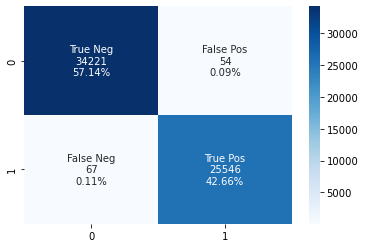

In [54]:
# altered from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

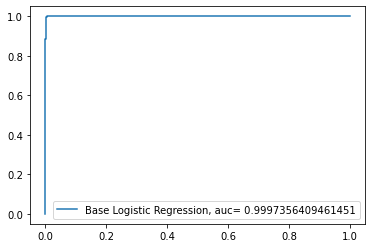

In [44]:
#ROC Curve
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(auc))
plt.legend(loc=4)
plt.show()